The main() function orchestrates the execution of these steps. **---** It loads and transforms the data, creates a graph from a polygon, consolidates intersections, saves the graph to a file, converts the graph to GeoDataFrames, saves nodes and edges to files, loads farm data, loads H3 GeoDataFrame, finds the closest OSM ID for each point in the GeoDataFrames, loads farm GeoDataFrame, loads loi data, loads H3 GeoDataFrame, filters H3 GeoDataFrame, and finally calculates the OD matrix. **---** The script is designed to be run as a **standalone program.**

In [122]:
# Import necessary libraries
from utils.cflp_function import *
from utils.calculate_od import *
import networkx as nx
import osmnx as ox
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
from shapely.ops import nearest_points

In [123]:
# Define constants
SHAPEFILE_PATH = "shapefiles/zh_poly.shp"
CUSTOM_FILTER = '["highway"]["area"!~"yes"]["access"!~"private"]["highway"~"motorway|motorway_link|trunk|trunk_link|primary|primary_link|secondary|secondary_link|tertiary|tertiary_link|road"]'
H3_GDF_FILEPATH = 'app_data/h3_polygons.shp'
TO_CRS = "EPSG:28992"
GRAPHML_FILEPATH = "osm_network/G.graphml"
NODES_FILEPATH = "osm_network/G_n.shp"
EDGES_FILEPATH = "osm_network/G_e.shp"

FARM_FILEPATH = 'farm/farm_new.shp'
APP_DATA_H3_GEOMETRY_FILEPATH = "./app_data/h3_geometry.shp"
APP_DATA_FARM_FILEPATH = "./app_data/farm.shp"
LOI_FILEPATH = './hex/loi.csv'
APP_DATA_H3_GEOMETRY_FILEPATH = './app_data/h3_geometry.shp'
COST_PER_KM = 0.69

This function loads geospatial data from a file and transforms the Coordinate Reference System (CRS) to the specified CRS.

In [124]:
def load_and_transform_data(file_path, crs):
    # Load data
    data = gpd.read_file(file_path)
    # Transform CRS
    data = data.to_crs(crs)
    return data

This function creates a graph from a polygon, which represents the study area. The graph is created based on a specified network type and custom filter, and is then projected to the specified CRS.

In [125]:
def create_graph_from_polygon(polygon, network_type, custom_filter, to_crs):
    # Create graph from polygon
    G_base = ox.graph_from_polygon(polygon, network_type=network_type, custom_filter=custom_filter)
    G_base = ox.project_graph(G_base, to_crs=to_crs)
    return G_base

 This function simplifies the topology of the graph by consolidating intersections within a specified tolerance.

In [126]:
def consolidate_intersections(G_base, tolerance, rebuild_graph, dead_ends):
    # Consolidate intersection to further simplify the topography of the graph
    G = ox.consolidate_intersections(G_base, tolerance=tolerance, rebuild_graph=rebuild_graph, dead_ends=dead_ends)
    return G

This function saves the graph to a file.

In [127]:
def save_graph_to_file(G, filepath):
    # Save graph to file
    ox.save_graphml(G, filepath=filepath)

This function converts lists to strings in the ‘highway’ column of the edges GeoDataFrame.

In [128]:
def convert_lists_to_strings(e):
    # Convert lists to strings
    e['highway'] = e['highway'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)

This function finds the closest OSM ID for each point in a GeoDataFrame.

In [129]:
def find_closest_osmid(gdf, n):
    # Find the closest OSM ID for each point in a GeoDataFrame
    gdf['closest_osmid'] = gdf['geometry'].apply(
        lambda location: n.loc[n['geometry'] == nearest_points(location, n.unary_union)[1], 'osmid'].iloc[0])

This function calculates the Origin-Destination (OD) matrix.

In [130]:
def calculate_od_matrix(farm_gdf, loi_gdf, cost_per_km):
    # Calculate OD matrix
    c, plant = calculate_od_matrix(farm_gdf, loi_gdf, cost_per_km=cost_per_km)
    return c, plant

The main() function orchestrates the execution of these steps. It loads and transforms the data, creates a graph from a polygon, consolidates intersections, saves the graph to a file, converts the graph to GeoDataFrames, saves nodes and edges to files, loads farm data, loads H3 GeoDataFrame, finds the closest OSM ID for each point in the GeoDataFrames, loads farm GeoDataFrame, loads loi data, loads H3 GeoDataFrame, filters H3 GeoDataFrame, and finally calculates the OD matrix.

In [131]:
def main():
    # Load and transform data
    pzh = load_and_transform_data(SHAPEFILE_PATH, 'EPSG:4326')
    polygon = pzh['geometry'].squeeze()
    
    # Create graph from polygon
    G_base = create_graph_from_polygon(polygon, 'drive', CUSTOM_FILTER, TO_CRS)
    

    ###
    # fig, ax = ox.plot_graph(G_base, node_size=2, node_color='tab:blue', edge_linewidth=1, edge_color= 'darkgray', figsize=(8,8), bgcolor='white')
    # # fig.savefig('./notebook_figures/G.eps',format='eps', dpi=1000,bbox_inches="tight")
    # fig.savefig("./G_base.png", format = 'png', dpi= 1000, bbox_inches="tight")
    ###


    # consolidate intersection to further simplify the topography of the graph
    G = consolidate_intersections(G_base, 200, True, False)
    

    ###
    # fig, ax = ox.plot_graph(G, node_size=2, node_color='tab:blue', edge_linewidth=1, edge_color= 'darkgray', figsize=(8,8), bgcolor='white')
    # # fig.savefig('./notebook_figures/G.eps',format='eps', dpi=1000, bbox_inches="tight")
    # fig.savefig("./G.png", format = 'png', dpi= 1000, bbox_inches="tight") #transparent=True
    ###
        

    # Save graph to file
    save_graph_to_file(G, GRAPHML_FILEPATH)
    
    # Convert graph to GeoDataFrames
    n, e = ox.graph_to_gdfs(G)
    
    # Save nodes and edges to files
    n[["geometry", "y", "x", "lon", "lat", "highway"]].to_file(NODES_FILEPATH)
    convert_lists_to_strings(e)
    e[["geometry","highway"]].to_file(EDGES_FILEPATH)
    n.crs


    # ###
    # t = gpd.read_file(SHAPEFILE_PATH)
    # n.head()
    # t.head()

    # fig, ax = plt.subplots(figsize=(10,12))
    # pzh.plot(ax=ax, color='gold', zorder=1)
    # t.plot(ax=ax, edgecolor='red', color="none", zorder=2)
    # e.plot(ax=ax, color='darkgray', linewidth=1, zorder=3)
    # n.plot(ax=ax, color='tab:blue',  markersize=1, zorder=4)

    # ax.set_axis_off()
    # plt.show()
    # fig.savefig("Diagram/osm_network.png", format='png', dpi=1000, bbox_inches="tight") #transparent=True
    # fig.savefig("Diagram/osm_network.eps", format='eps', dpi=1000, bbox_inches="tight")
    # ###


    # Load farm data
    farm = gpd.read_file(FARM_FILEPATH)
    
    # Load H3 GeoDataFrame
    h3_gdf = gpd.read_file(H3_GDF_FILEPATH)  # This will now load 'h3_polygons.shp'
    
    print(n.columns)
    # Find the closest OSM ID for each point in the GeoDataFrames
    find_closest_osmid(h3_gdf, n) 
    h3_gdf['y'] = h3_gdf['geometry'].y
    h3_gdf['x'] = h3_gdf['geometry'].x
    h3_gdf.to_file(APP_DATA_H3_GEOMETRY_FILEPATH)
    find_closest_osmid(farm, n) 
    farm.to_file(APP_DATA_FARM_FILEPATH)
    
    # Load farm GeoDataFrame
    farm_gdf = gpd.read_file(APP_DATA_FARM_FILEPATH)
    
    # Load loi data
    loi = gpd.read_file(LOI_FILEPATH)
    
    # Load H3 GeoDataFrame
    h3_gdf = gpd.read_file(APP_DATA_H3_GEOMETRY_FILEPATH)
    
    # Filter H3 GeoDataFrame
    loi_gdf = h3_gdf[h3_gdf['hex9'].isin(loi.hex9)]
    
    # Calculate OD matrix
    c, plant = calculate_od_matrix(farm_gdf, loi_gdf, COST_PER_KM)

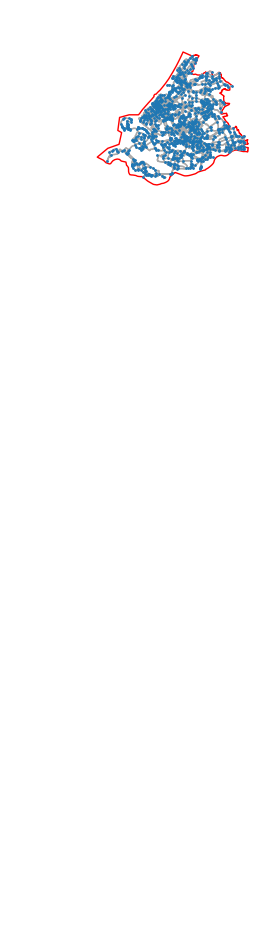

Index(['osmid_original', 'y', 'x', 'street_count', 'lon', 'lat', 'highway',
       'ref', 'geometry'],
      dtype='object')


KeyError: 'osmid'

In [132]:
if __name__ == "__main__":
    main()